# ERDDAP API

[Tutorial](https://github.com/ioos/erddapy/blob/main/notebooks/01a-griddap.ipynb)

In [1]:


import os
os.chdir('/home/thiagocaminha/projects/woww_analysis/')

from erddapy import ERDDAP
import json
import xarray as xr
import pandas as pd
import numpy as np
import math
from typing import Union
from scripts.erddap import WOWWErdappData

from datetime import datetime, timedelta

%load_ext autoreload
%autoreload 2

/home/thiagocaminha/.pyenv/versions/3.8.12/envs/remobs_global/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Basic Utilization

In [82]:
server="https://pae-paha.pacioos.hawaii.edu/erddap/"
protocol="griddap"
dataset_id="ww3_global"

e = ERDDAP(server=server, protocol=protocol)
e.dataset_id = dataset_id

In [83]:
e.griddap_initialize()

In [117]:
e

In [118]:
print(f"variables in this dataset:\n\n{e.variables}")
print(
    f"\nconstraints of this dataset:\n\n{json.dumps(e.constraints, indent=1)}"
)

variables in this dataset:

['Tdir', 'Tper', 'Thgt', 'sdir', 'sper', 'shgt', 'wdir', 'wper', 'whgt']

constraints of this dataset:

{
 "time>=": "2023-02-04T18:00:00Z",
 "time<=": "2023-02-04T18:00:00Z",
 "time_step": 1,
 "depth>=": 0.0,
 "depth<=": 0.0,
 "depth_step": 1,
 "latitude>=": -77.5,
 "latitude<=": 77.5,
 "latitude_step": 1,
 "longitude>=": 0.0,
 "longitude<=": 359.5,
 "longitude_step": 1
}


In [120]:
e.longitude = 330
e.latitude = -2
e.time = '2023-01-29T00:00:00Z'

## ETL development

- Design get_bash_data to grab forecast data as default
  - Consider lowest maximum datetime available either from ww3 (waves), ncep (winds) and ?? (currents)

## WW3

### RAW 

In [2]:
# EXTRACT
wd = WOWWErdappData(server="https://pae-paha.pacioos.hawaii.edu/erddap/",
                    protocol="griddap",
                    dataset_id="ww3_global",
                    initialize=True)
# 3m27s longitude=(305,333),latitude=(-35,4)

wd.set_vars_constraints(variables=['Tdir', 'Tper', 'Thgt',
                                    'sdir','sper','shgt',
                                    'wdir','wper','whgt'],
                        longitude=305,#(305,333),
                        latitude=-35,#(-35,4),
                        start_date=(datetime.utcnow()-timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ"),
                        correct_pos=False)

ww3 = wd.grab_batch_data(response_type="pandas")


In [3]:

#TRANSFORM
ww3.columns = wd.process_var_labels(ww3)
ww3 = wd.rename_var_labels(ww3)


In [6]:
# ww3 = wd.select_vars(ww3)
ww3['tdir_windrose'] = wd.get_direc_quadrant(data=ww3,direc_var='tdir')
ww3['sdir_windrose'] = wd.get_direc_quadrant(data=ww3,direc_var='sdir')
ww3['wdir_windrose'] = wd.get_direc_quadrant(data=ww3,direc_var='wdir')

# LOAD


In [7]:
ww3

,date_time,depth,latitude,longitude,tdir,tper,thgt,sdir,sper,shgt,wdir,wper,whgt,tdir_windrose,sdir_windrose,wdir_windrose
0,2023-09-02T02:00:00Z,0.0,-35.0,305.0,71.0,5.319148,1.11,93.0,9.770000,0.31,65.0,5.30,1.05,ENE,E,ENE
1,2023-09-02T03:00:00Z,0.0,-35.0,305.0,72.0,5.376344,1.03,94.0,9.790000,0.30,67.0,5.37,0.98,ENE,E,ENE
2,2023-09-02T04:00:00Z,0.0,-35.0,305.0,80.0,5.464480,0.96,93.0,9.830000,0.30,69.0,5.47,0.90,E,E,ENE
3,2023-09-02T05:00:00Z,0.0,-35.0,305.0,81.0,5.586592,0.90,72.0,5.570000,0.83,NaN,NaN,NaN,E,ENE,NaN
4,2023-09-02T06:00:00Z,0.0,-35.0,305.0,82.0,5.681818,0.86,74.0,5.680000,0.78,NaN,NaN,NaN,E,ENE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2023-09-08T14:00:00Z,0.0,-35.0,305.0,108.0,10.309278,1.22,119.0,10.250000,1.19,NaN,NaN,NaN,ESE,ESE,NaN
157,2023-09-08T15:00:00Z,0.0,-35.0,305.0,108.0,10.309278,1.24,122.0,10.290000,1.22,NaN,NaN,NaN,ESE,ESE,NaN
158,2023-09-08T16:00:00Z,0.0,-35.0,305.0,109.0,10.416667,1.25,123.0,10.349999,1.23,NaN,NaN,NaN,ESE,ESE,NaN
159,2023-09-08T17:00:00Z,0.0,-35.0,305.0,109.0,10.416667,1.26,124.0,10.420000,1.24,NaN,NaN,NaN,ESE,SE,NaN


<AxesSubplot:xlabel='date_time'>

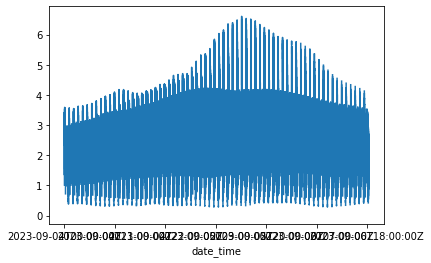

In [9]:
ww3.set_index('date_time').loc['2023-09-04':,'thgt'].plot()

In [3]:
wd = WOWWErdappData(server="https://pae-paha.pacioos.hawaii.edu/erddap/",
            protocol="griddap",
            dataset_id="ncep_global")

In [4]:
wd.set_vars_constraints(variables=['ugrd10m', 'vgrd10m'],
                        longitude=(305,333),
                        latitude=(-35,4),
                start_date=(datetime.utcnow()-timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ"),
                correct_pos=False)

gfs = wd.grab_batch_data(response_type="pandas")

gfs.columns = wd.process_var_labels(gfs)
gfs = wd.rename_var_labels(gfs)
gfs = wd.select_vars(gfs)
gfs['wspd'] = wd.calc_wind_veloc(gfs)
gfs['wdir'] = wd.calc_wind_direc(gfs)
gfs['wdir_windrose'] = wd.get_direc_quadrant(gfs)

In [5]:
gfs

,date_time,latitude,longitude,uw,vw,wspd,wdir,dir_quadrants
0,2023-07-23T00:00:00Z,-35.0,305.0,4.482549,-7.959366,9.134810,299.387302,WNW
1,2023-07-23T00:00:00Z,-35.0,305.5,1.082549,-7.399366,7.478137,278.323488,W
2,2023-07-23T00:00:00Z,-35.0,306.0,2.182549,-7.819367,8.118252,285.595530,WNW
3,2023-07-23T00:00:00Z,-35.0,306.5,0.332549,-9.569366,9.575143,271.990307,W
4,2023-07-23T00:00:00Z,-35.0,307.0,0.352549,-10.729366,10.735157,271.881965,W
...,...,...,...,...,...,...,...,...
310702,2023-07-31T12:00:00Z,4.0,331.0,-3.068423,4.762478,5.665370,122.793328,ESE
310703,2023-07-31T12:00:00Z,4.0,331.5,-3.768423,5.642478,6.785173,123.737640,ESE
310704,2023-07-31T12:00:00Z,4.0,332.0,-2.658423,5.612478,6.210243,115.345179,ESE
310705,2023-07-31T12:00:00Z,4.0,332.5,-2.678423,5.712478,6.309227,115.120581,ESE


<AxesSubplot:>

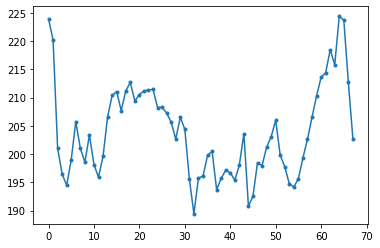

In [119]:
gfs.wdir.plot(marker='.')